# Mechanistic analysis of H/Pt(111) from LAMMPS MD trajectory

## Header

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import math
from tqdm.auto import tqdm

import lmpdump as lmpdump    # Use lmpdump.py parser
from sitator.util import PBCCalculator
from scipy.sparse.csgraph import connected_components

## Load LAMMPS trajectory

In [120]:
T = input('Enter the temperature in K : ')
file_dmp = T + 'K/finer_res/' + input('Enter the name of the LAMMPS DUMP file : ')

print('Loading trajectory...')
dmp = lmpdump.lmpdump(file_dmp, loadmode='all')

steps = []
for s in dmp.finaldict.keys():    # keys = time steps
    steps.append(s)
N_steps = np.array(steps).size    # Number of time steps
print('Number of time steps = ' + str(N_steps))

dt = float(input('Enter the timestep in fs : '))

Enter the temperature in K : 900
Enter the name of the LAMMPS DUMP file : xyzc_E2.dmp
Loading trajectory...
Done with loading 50002 snapshots in 1291.60s.
Number of time steps = 50001
Enter the timestep in fs : 0.1


## Extract unit cell information

In [121]:
file_dat = T + 'K/' + input('Enter the name of the input LAMMPS DATA file : ')
dat = open(file_dat, 'r')
dat_lines = dat.readlines()
dat_lines = [line.split() for line in dat_lines]

for line_index, line in enumerate(dat_lines):
    if line:
        for l in line:
            
            if l == 'atoms':
                N_atoms = int(line[0])    # Number of atoms
            
            elif l == 'types':
                N_types = int(line[0])    # Number of atom types
            
            elif l == 'Atoms':
                start = line_index + 2    # Start line for atomic coordinates

N_Pt = 0    # Number of Pt atoms
N_H = 0    # Number of H atoms
z_layers = []    # Layer heights
for line in dat_lines[start:]:
    
    if int(line[1]) == 1:    # Type 1 = Pt
        N_Pt += 1
        z = float(line[-1])
        if z not in z_layers:
            z_layers.append(z)
    
    else:    # Type 2 = H
        N_H += 1

N_layers = len(z_layers)    # Number of layers

dz_avg = 0    # Average interlayer distance
for i in range(N_layers-1):
    dz_avg += z_layers[i+1] - z_layers[i]
dz_avg = dz_avg / (N_layers-1)

dr_avg = dz_avg * math.sqrt(3/2)    # Average interatomic distance
c2v_avg = dr_avg * math.sqrt(3/8)    # Average centroid to vertex distance
h2v_avg = dr_avg / math.sqrt(3)    # Average hollow to vertex distance

dat.close()

print('Number of Pt atoms = ' + str(N_Pt))
print('Number of H atoms = ' + str(N_H))
print('Number of layers = ' + str(N_layers))
print('Layer heights (Ang) = ')
print(z_layers)
print('Average interlayer distance = ' + "{:.3f}".format(dz_avg) + ' Ang')
print('Average interatomic distance = ' + "{:.3f}".format(dr_avg) + ' Ang')
print('Average centroid to vertex distance = ' + "{:.3f}".format(c2v_avg) + ' Ang')
print('Average hollow to vertex distance = ' + "{:.3f}".format(h2v_avg) + ' Ang')
print('\n')

print('Unit cell information extracted.')

Enter the name of the input LAMMPS DATA file : PtH2.data
Number of Pt atoms = 864
Number of H atoms = 448
Number of layers = 6
Layer heights (Ang) = 
[28.300000000000004, 30.563213055223336, 32.82642611044667, 35.08963916567, 37.35285222089334, 39.61606527611667]
Average interlayer distance = 2.263 Ang
Average interatomic distance = 2.772 Ang
Average centroid to vertex distance = 1.697 Ang
Average hollow to vertex distance = 1.600 Ang


Unit cell information extracted.


## H state classification

In [122]:
print('Parsing trajectory to classify H species...')

file_out = T + 'K/finer_res/H_species_E2.txt'
out = open(file_out, 'w')

for s in tqdm(steps):
    
    t = dt * float(s) * 10**(-3)    # Time in ps
    out.write('Time = ' + "{:.2f}".format(t) + ' ps\n\n')
    
    xlo_bound = dmp.finaldict[s][0][0]    # Box bounds
    xhi_bound = dmp.finaldict[s][0][1]
    xy = dmp.finaldict[s][0][2]

    ylo_bound = dmp.finaldict[s][0][3]
    yhi_bound = dmp.finaldict[s][0][4]
    xz = dmp.finaldict[s][0][5]

    zlo = dmp.finaldict[s][0][6]
    zhi = dmp.finaldict[s][0][7]
    yz = dmp.finaldict[s][0][8]

    xlo = xlo_bound - min(0.0, xy, xz, xy+xz)    # Box parameters
    xhi = xhi_bound - max(0.0, xy, xz, xy+xz)
    ylo = ylo_bound - min(0.0, yz)
    yhi = yhi_bound - max(0.0, yz)
    
    lat = np.array([[xhi-xlo, 0.0, 0.0], [xy, yhi-ylo, 0.0], [xz, yz, zhi-zlo]])    # Lattice matrix
    pbc = PBCCalculator(lat)    # Periodic boundary condition

    ID_Pt_all = []    # All Pt atoms
    r_Pt_all = []
    
    ID_Pt_surf = []    # Surface Pt atoms
    r_Pt_surf = []
    
    ID_H1_sub = []    # Subsurface H1
    r_H1_sub = []

    ID_H1_surf = []    # Surface H1
    r_H1_surf = []

    ID_H2_surf = []    # Surface H2
    r_H2_surf = []
    
    ID_H2_gas = []    # Gaseous H2
    r_H2_gas = []

    for atom in range(N_atoms):
        
        ID = dmp.finaldict[s][1]['id'][atom]
        Type = dmp.finaldict[s][1]['type'][atom]
        x = dmp.finaldict[s][1]['x'][atom]
        y = dmp.finaldict[s][1]['y'][atom]
        z = dmp.finaldict[s][1]['z'][atom]
        r = np.array([x, y, z])
        CN_H = dmp.finaldict[s][1]['c_coord'][atom]
        
        if Type == 1:    # Type 1 = Pt
            
            ID_Pt_all.append(ID)
            r_Pt_all.append(r)
            
            if (abs(z - z_layers[0]) < 0.1 * dz_avg) or (z < z_layers[0]):    # Bottom layer / adatoms
                ID_Pt_surf.append(ID)
                r_Pt_surf.append(r)
                
            elif (abs(z - z_layers[-1]) < 0.1 * dz_avg) or (z > z_layers[-1]):    # Top layer / adatoms
                ID_Pt_surf.append(ID)
                r_Pt_surf.append(r)
        
        else:    # Type 2 = H
            
            if CN_H == 0:    # 0 = nonbonded
                
                if (z < z_layers[-1]) and (z > z_layers[0]):
                    ID_H1_sub.append(ID)
                    r_H1_sub.append(r)
                
                else:
                    ID_H1_surf.append(ID)
                    r_H1_surf.append(r)
            
            else:    # 1 = bonded
                
                if (abs(z - z_layers[0]) <= 0.8 * dz_avg) or (abs(z - z_layers[-1]) <= 0.8 * dz_avg):
                    ID_H2_surf.append(ID)
                    r_H2_surf.append(r)
                
                else:
                    ID_H2_gas.append(ID)
                    r_H2_gas.append(r)
                
    r_Pt_all = np.array(r_Pt_all)
    r_Pt_surf = np.array(r_Pt_surf)
    r_H1_sub = np.array(r_H1_sub)
    r_H1_surf = np.array(r_H1_surf)
    r_H2_surf = np.array(r_H2_surf)
    r_H2_gas = np.array(r_H2_gas)
    
    N_H1_sub = len(ID_H1_sub)    # Number of H atoms
    N_H1_surf = len(ID_H1_surf)
    N_H2_surf = len(ID_H2_surf)
    N_H2_gas = len(ID_H2_gas)
    N_H_tot = N_H1_sub + N_H1_surf + N_H2_surf + N_H2_gas
    
    f_H1_sub = 100 * N_H1_sub / N_H_tot    # Percent fraction of H atoms
    f_H1_surf = 100 * N_H1_surf / N_H_tot
    f_H2_surf = 100 * N_H2_surf / N_H_tot
    f_H2_gas = 100 * N_H2_gas / N_H_tot
    
    #####
    
    out.write('State A: Subsurface H1\n')
    
    if N_H1_sub == 0:
        out.write('None\n')
        
    else:
        out.write('Total number of atoms = ' + str(N_H1_sub) + '\n')
        out.write('Total percentage = ' + "{:.2f}".format(f_H1_sub) + '\n')
        out.write('ID-H\tCN-Pt\tID-Pt\n')
        
        r_HPt = np.concatenate((r_H1_sub, r_Pt_all), axis=0)
        rij = pbc.pairwise_distances(r_HPt)[:N_H1_sub, N_H1_sub:]    # H-Pt distances only
        connectivity = (rij <= 1.2 * c2v_avg)
        
        for i, ID in enumerate(ID_H1_sub):

            out.write(str(ID) + '\t')
            
            CN_Pt = 0
            ID_Pt = []
            for j, bond in enumerate(connectivity[i]):    # H-Pt bonds only
                if bond:
                    CN_Pt += 1
                    ID_Pt.append(j+1)
            
            out.write(str(CN_Pt) + '\t')
            
            for j in ID_Pt:
                out.write(str(j) + ' ')
            
            out.write('\n')
        
    out.write('\n')
    
    #####
    
    out.write('State B: Surface H1\n')
    
    if N_H1_surf == 0:
        out.write('None\n')

    else:
        out.write('Total number of atoms = ' + str(N_H1_surf) + '\n')
        out.write('Total percentage = ' + "{:.2f}".format(f_H1_surf) + '\n')
        out.write('ID-H\tCN-Pt\tID-Pt\n')

        r_HPt = np.concatenate((r_H1_surf, r_Pt_surf), axis=0)
        rij = pbc.pairwise_distances(r_HPt)[:N_H1_surf, N_H1_surf:]    # H-Pt distances only
        connectivity = (rij <= 1.3 * h2v_avg)
        
        N_hollow = 0    # Surface sites
        N_bridge = 0
        N_top = 0
        N_other = 0
        for i, ID in enumerate(ID_H1_surf):
            
            out.write(str(ID) + '\t')
            
            CN_Pt = 0
            ID_Pt = []
            for j, bond in enumerate(connectivity[i]):
                if bond:
                    CN_Pt += 1
                    ID_Pt.append(ID_Pt_surf[j])
            
            if CN_Pt == 3:
                N_hollow += 1
            
            elif CN_Pt == 2:
                N_bridge += 1
            
            elif CN_Pt == 1:
                N_top += 1
            
            else:    # 0 or >3 (noise)
                N_other += 1
            
            out.write(str(CN_Pt) + '\t')
            
            for j in ID_Pt:
                out.write(str(j) + ' ')
            
            out.write('\n')
        
        f_hollow = 100 * N_hollow / N_H1_surf
        f_bridge = 100 * N_bridge / N_H1_surf
        f_top = 100 * N_top / N_H1_surf
        f_other = 100 * N_other / N_H1_surf
        
        out.write('Total number of hollow, bridge, top, other = ' + str(N_hollow) + ' ' + str(N_bridge) + ' ' + str(N_top) + ' ' + str(N_other) + '\n')
        out.write('Percentages = ' + "{:.2f}".format(f_hollow) + ' ' + "{:.2f}".format(f_bridge) + ' ' + "{:.2f}".format(f_top) + ' ' + "{:.2f}".format(f_other) + '\n')

    out.write('\n')
    
    #####
    
    out.write('State C: Surface H2\n')
    
    N_mol = 0    # Number of H2 molecules
    
    if N_H2_surf == 0:
        out.write('None\n')
    
    else:
        out.write('Total number of atoms = ' + str(N_H2_surf) + '\n')
        out.write('Total percentage = ' + "{:.2f}".format(f_H2_surf) + '\n')
        out.write('ID-mol\tID-Ha\tID-Hb\tCN-Pt\tID-Pt\n')
        
        r_HPt = np.concatenate((r_H2_surf, r_Pt_surf), axis=0)
        rij = pbc.pairwise_distances(r_HPt)[:N_H2_surf]    # H-H and H-Pt distances
        connectivity_HH = (rij[:, :N_H2_surf] <= 1.0)    # H-H distances
        connectivity_HPt = (rij[:, N_H2_surf:] <= 0.8 * dz_avg)    # H-Pt distances
        
        ID_mol = np.zeros(N_H2_surf).astype(int)    # Molecule IDs
        for i, connectivity in enumerate(connectivity_HH):
            for j, bond in enumerate(connectivity):
                if j != i:
                    if bond:
                        
                        if ID_mol[j] == 0:    # Partner not yet assigned to a molecule
                            N_mol += 1
                            ID_mol[i] = N_mol
                            ID_mol[j] = N_mol
                        
                        else:    # Partner already assigned to a molecule
                            ID_mol[i] = ID_mol[j]
        
        N_missing = 0    # Number of atoms missing a partner
        ls_mol = []    # List of molecules
        for i, mol_i in enumerate(ID_mol):
            
            index_Ha = i
            ID_Ha = ID_H2_surf[i]
            
            CN_Pt = 0
            ID_Pt = []

            if mol_i == 0:    # Not assigned to a molecule
                N_missing += 1
                out.write(str(mol_i) + '\t' + str(ID_Ha) + '\tNA\t')
                
                for j, bond in enumerate(connectivity_HPt[index_Ha]):
                    if bond:
                        CN_Pt += 1
                        if ID_Pt_surf[j] not in ID_Pt:
                            ID_Pt.append(ID_Pt_surf[j])
                
                out.write(str(CN_Pt) + '\t')
                
                if CN_Pt == 0:    # Something is wrong
                    out.write('NA')
                
                else:
                    for j in ID_Pt:
                        out.write(str(j) + ' ')
            
            else:
                if mol_i not in ls_mol:   # Only list each molecule once
                    ls_mol.append(mol_i)
                    out.write(str(mol_i) + '\t' + str(ID_Ha) + '\t')
                    
                    for j, mol_j in enumerate(ID_mol):    # Identify the partner
                        if j > i:
                            if mol_j == mol_i:
                                index_Hb = j
                                ID_Hb = ID_H2_surf[j]
                                out.write(str(ID_Hb) + '\t')
                    
                    connectivity_HPt_ab = np.concatenate(([connectivity_HPt[index_Ha]], [connectivity_HPt[index_Hb]]), axis=0)
                    
                    for connectivity in connectivity_HPt_ab:    # Check both Ha-Pt and Hb-Pt
                        for j, bond in enumerate(connectivity):
                            if bond:
                                CN_Pt += 1
                                if ID_Pt_surf[j] not in ID_Pt:
                                    ID_Pt.append(ID_Pt_surf[j])
                    
                    out.write(str(CN_Pt) + '\t')
                    
                    if CN_Pt == 0:    # Something is wrong
                        out.write('NA')                    
                    
                    else:
                        for j in ID_Pt:
                            out.write(str(j) + ' ')
            
            out.write('\n')
            
        out.write('Number of H2 molecules = ' + str(N_mol) + '\n')
        out.write('Number of atoms missing a partner = ' + str(N_missing) + '\n')
        
    out.write('\n')
    
    #####
    
    out.write('State D: Gaseous H2\n')
    
    N_mol_gas = 0    # Number of gaseous H2 molecules
    
    if N_H2_gas == 0:
        out.write('None\n')
    
    else:
        out.write('Total number of atoms = ' + str(N_H2_gas) + '\n')
        out.write('Total percentage = ' + "{:.2f}".format(f_H2_gas) + '\n')
        out.write('ID-mol\tID-Ha\tID-Hb\n')
        
        rij = pbc.pairwise_distances(r_H2_gas)
        connectivity_HH = (rij <= 1.0)
        
        ID_mol = np.zeros(N_H2_gas).astype(int)    # Molecule IDs
        for i, connectivity in enumerate(connectivity_HH):
            for j, bond in enumerate(connectivity):
                if j != i:
                    if bond:
                        
                        if ID_mol[j] == 0:    # Partner not yet assigned to a molecule
                            N_mol_gas += 1
                            N_mol += 1
                            ID_mol[i] = N_mol
                            ID_mol[j] = N_mol
                        
                        else:    # Partner already assigned to a molecule
                            ID_mol[i] = ID_mol[j]
        
        N_missing = 0    # Number of atoms missing a partner
        ls_mol = []    # List of molecules
        for i, mol_i in enumerate(ID_mol):
            
            ID_Ha = ID_H2_gas[i]
            
            if mol_i == 0:    # Not assigned to a molecule
                N_missing += 1
                out.write(str(mol_i) + '\t' + str(ID_Ha) + '\tNA\n')
            
            else:
                if mol_i not in ls_mol:   # Only list each molecule once
                    ls_mol.append(mol_i)
                    out.write(str(mol_i) + '\t' + str(ID_Ha) + '\t')
                    
                    for j, mol_j in enumerate(ID_mol):    # Identify the partner
                        if j > i:
                            if mol_j == mol_i:
                                ID_Hb = ID_H2_gas[j]
                                out.write(str(ID_Hb) + '\n')
        
        out.write('Number of H2 molecules = ' + str(N_mol_gas) + '\n')
        out.write('Number of atoms missing a partner = ' + str(N_missing) + '\n')
    
    out.write('\n')
    
    #####

out.close()
print('Classification done > H_species.txt')

Parsing trajectory to classify H species...


Classification done > H_species.txt


## H state distribution

In [123]:
for T in range(900,901,150):
    
    file_out = str(T) + 'K/finer_res/H_distribution_E2.txt'
    out = open(file_out, 'w')
    
    out.write('Time (ps)\t%_hollow\t%_bridge\t%_top\t%_StateA\t%_StateB\t%_StateC\t%_StateD\n')
    
    file_log = str(T) + 'K/finer_res/H_species_E2.txt'
    log = open(file_log, 'r')
    log_lines = log.readlines()
    log_lines = [line.split() for line in log_lines]
    
    for line_index, line in tqdm(enumerate(log_lines)):
        
        if 'Time' in line:
            
            if line_index == 0:
                out.write(line[2] + '\t')
            
            else:
                line_out = '%f\t%f\t%f\t%f\t%f\t%f\t%f\n'%(f_hollow, f_bridge, f_top, f_StateA, f_StateB, f_StateC, f_StateD)
                out.write(line_out)
                
                out.write(line[2] + '\t')
        
        elif 'A:' in line:

            if 'None' in log_lines[line_index+1]:
                f_StateA = 0.0
            
            else:
                f_StateA = float(log_lines[line_index+2][-1])
        
        elif 'B:' in line:
            
            if 'None' in log_lines[line_index+1]:
                f_StateB = 0.0
            
            else:
                f_StateB = float(log_lines[line_index+2][-1])
        
        elif 'Percentages' in line:
            f_hollow = float(line[2])
            f_bridge = float(line[3])
            f_top = float(line[4])
        
        elif 'C:' in line:
            
            if 'None' in log_lines[line_index+1]:
                f_StateC = 0.0
            
            else:
                f_StateC = float(log_lines[line_index+2][-1])
                
        elif 'D:' in line:
            
            if 'None' in log_lines[line_index+1]:
                f_StateD = 0.0
            
            else:
                f_StateD = float(log_lines[line_index+2][-1])
        
        if line_index == len(log_lines)-1:
            line_out = '%f\t%f\t%f\t%f\t%f\t%f\t%f\n'%(f_hollow, f_bridge, f_top, f_StateA, f_StateB, f_StateC, f_StateD)
            out.write(line_out)
    
    log.close()
    out.close()

print('Analysis done > H_distribution.txt')

Analysis done > H_distribution.txt


## H state history

In [128]:
print('Generating H state history at each temperature...')

for T in range(450,901,150):
    
    file_out = str(T) + 'K/finer_res/H_history_E2.txt'
    out = open(file_out, 'w')
    
    out.write('ID-H\t')
    for t in range(0,N_steps):
        out.write(str(t) + (6 - len(str(t))) * ' ')
    out.write('\n')
    
    file_log = str(T) + 'K/finer_res/H_species_E2.txt'
    log = open(file_log, 'r')
    log_lines = log.readlines()
    log_lines = [line.split() for line in log_lines]
    
    history = np.empty((N_H, N_steps), dtype=object)
    start = 0
    
    for frame in tqdm(range(0,N_steps)):
        
        for line_index, line in enumerate(log_lines[start:]):
            if line:
                
                if 'Time' in line:
                    t = float(line[2])
                    
                    if t > 0:
                        start += line_index + 1
                        break
                    
                elif 'State' in line:
                    
                    if 'None' in log_lines[start+line_index+1]:
                        continue
                    
                    elif 'A:' in line:    # Subsurface H1
                        state = 'A'
                    
                    elif 'B:' in line:    # Surface H1
                        state = 'B'
                    
                    elif 'C:' in line:    # Surface H2
                        state = 'C'
                    
                    elif 'D:' in line:    # Gaseous H2
                        state = 'D'

                elif line[0].isdigit():
                    
                    if state == 'A':
                        ID = int(line[0])
                        history[ID-N_Pt-1, frame] = state

                    elif state == 'B':    # Append with site type
                        
                        ID = int(line[0])
                        CN = int(line[1])
                        
                        if CN == 1:
                            history[ID-N_Pt-1, frame] = state + 't'
                        
                        elif CN == 2:
                            history[ID-N_Pt-1, frame] = state + 'b'
                        
                        elif CN == 3:
                            history[ID-N_Pt-1, frame] = state + 'h'
                        
                        else:
                            history[ID-N_Pt-1, frame] = state + '?'
                    
                    elif (state == 'C') or (state == 'D'):    # Append with partner ID
                        
                        ID_a = int(line[1])
                        
                        if line[2] == 'NA':
                            history[ID_a-N_Pt-1, frame] = state + '?'
                        else:
                            ID_b = int(line[2])
                            history[ID_a-N_Pt-1, frame] = state + line[2]
                            history[ID_b-N_Pt-1, frame] = state + line[1]
                        
    for atom_index, atom in enumerate(range(N_Pt+1, N_Pt+1+N_H)):
        out.write(str(atom) + '\t')
        
        for frame in range(N_steps):
            state = history[atom_index, frame]
            
            if state == None:
                out.write('?     ')
            else:
                out.write(state + (6 - len(state)) * ' ')
            
        out.write('\n')
    
    np.save(str(T) + 'K/finer_res/history_E2.npy', history)
    log.close()
    out.close()

print('History done > H_history.txt')

Generating H state history at each temperature...


History done > H_history.txt


## H state residence times for reactive events

In [135]:
print('Analyzing H state residence times for reactive events...')

file_log = str(T) + 'K/finer_res/H_species_E2.txt'
log = open(file_log, 'r')
log_lines = log.readlines()
log_lines = [line.split() for line in log_lines]

history = np.load(str(T) + 'K/finer_res/history_E2.npy', allow_pickle=True)
#history[388,149] = 'D1254'    # 750K fix
#history[389,149] = 'D1253'
#history[313,21775] = 'D1038'    # 900K fix
#history[345,18448] = 'D1209'

file_out = str(T) + 'K/finer_res/H_rxn_E2.txt'
out = open(file_out, 'w')
out.write('Rxn\tType\tInitial_time\tFinal_time\tDuration\tID_Ha\tID_Hb\tInitial_Ha\tInitial_Hb\tFinal_Ha\tFinal_Hb\n')

N_chemisorb = 0    # D-(C-)-B
N_chemisorb_attempt = 0    # D-C-D
N_desorb = 0    # B-(C-)-D
N_desorb_attempt = 0    # B-C-B
N_scramble = 0    # Dx-Dy
N_rxn = 0
N_total = 0

for frame in tqdm(range(1,N_steps)):
    
    s_now = steps[frame]
    s_prev = steps[frame-1]
    
    t_now = dt * s_now * 10**(-3)
    t_prev = dt * s_prev * 10**(-3)
    
    partners = []
    for atom_index, atom in enumerate(history):
        
        ID_Ha = N_Pt + atom_index + 1
        if ID_Ha not in partners:
            
            Ha_now = atom[frame]
            Ha_prev = atom[frame-1]
            
            #####
            
            if 'B' in Ha_now:
                
                if 'D' in Ha_prev:    # Direct chemisorption (D-B)
                    
                    rxn = 'Direct_chemisorption'
                    N_rxn += 1
                    N_total += 1
                    N_chemisorb += 1
                    duration = t_now - t_prev
                    partners.append(ID_Ha)
                    
                    if Ha_prev[1:].isdigit():
                        
                        ID_Hb = int(Ha_prev[1:])
                        partners.append(ID_Hb)
                        
                        Hb_now = history[ID_Hb-N_Pt-1, frame]
                        Hb_prev = history[ID_Hb-N_Pt-1, frame-1]
                        
                    else:
                        ID_Hb = 'NA'
                        Hb_now = 'NA'
                        Hb_prev = 'NA'
                    
                    line_out = '%i\t%s\t%f\t%f\t%f\t%i\t%s\t%s\t%s\t%s\t%s\n'%(N_total, rxn, t_prev, t_now, duration, ID_Ha, str(ID_Hb), Ha_prev, Hb_prev, Ha_now, Hb_now)
                    out.write(line_out)
                    
                elif 'C' in Ha_prev:
                    if frame > 1:
                        
                        for frame_past in range(frame-2,-1,-1):    # Scan backward to determine rxn
                            
                            s_past = steps[frame_past]
                            t_past = dt * s_past * 10**(-3)
                            Ha_past = atom[frame_past]
                            
                            if 'C' in Ha_past:
                                continue
                            
                            elif 'D' in Ha_past:    # Indirect chemisorption (D-C-B)
                                
                                rxn = 'Indirect_chemisorption'
                                N_rxn += 1
                                N_total += 1
                                N_chemisorb += 1
                                duration = t_now - t_past
                                partners.append(ID_Ha)
                                
                                if Ha_past[1:].isdigit():    # State D
                                    
                                    ID_Hb = int(Ha_past[1:])
                                    partners.append(ID_Hb)
                                    
                                    Hb_now = history[ID_Hb-N_Pt-1, frame]
                                    Hb_past = history[ID_Hb-N_Pt-1, frame_past]
                                    
                                else:
                                    ID_Hb = 'NA'
                                    Hb_now = 'NA'
                                    Hb_past = 'NA'
                                    
                                line_out = '%i\t%s\t%f\t%f\t%f\t%i\t%s\t%s\t%s\t%s\t%s\n'%(N_total, rxn, t_past, t_now, duration, ID_Ha, str(ID_Hb), Ha_past, Hb_past, Ha_now, Hb_now)
                                out.write(line_out)
                                break
                            
                            elif 'B' in Ha_past:    # Desorption attempt (B-C-B)
                                
                                rxn = 'Desorption_attempt'
                                N_desorb_attempt += 1
                                N_total += 1
                                duration = t_now - t_past
                                partners.append(ID_Ha)
                                
                                if Ha_prev[1:].isdigit():    # State C
                                    
                                    ID_Hb = int(Ha_prev[1:])
                                    partners.append(ID_Hb)
                                    
                                    Hb_now = history[ID_Hb-N_Pt-1, frame]
                                    Hb_past = history[ID_Hb-N_Pt-1, frame_past]
                                    
                                else:
                                    ID_Hb = 'NA'
                                    Hb_now = 'NA'
                                    Hb_past = 'NA'
                                
                                line_out = '%s\t%s\t%f\t%f\t%f\t%i\t%s\t%s\t%s\t%s\t%s\n'%(str(N_total)+'X', rxn, t_past, t_now, duration, ID_Ha, str(ID_Hb), Ha_past, Hb_past, Ha_now, Hb_now)
                                out.write(line_out)
                                break
            
            #####
            
            elif 'D' in Ha_now:
                
                if 'D' in Ha_prev:    # Direct scrambling (Dx-Dy)
                    
                    if Ha_now[1:].isdigit() and Ha_prev[1:].isdigit():
                        
                        ID_Hb = int(Ha_now[1:])
                        if ID_Hb != int(Ha_prev[1:]):
                            
                            rxn = 'Direct_scramble'
                            N_rxn += 1
                            N_total += 1
                            N_scramble += 1
                            duration = t_now - t_prev
                            partners.append(ID_Ha)
                            partners.append(ID_Hb)
                            
                            Hb_now = history[ID_Hb-N_Pt-1, frame]
                            Hb_prev = history[ID_Hb-N_Pt-1, frame-1]
                            
                            line_out = '%i\t%s\t%f\t%f\t%f\t%i\t%i\t%s\t%s\t%s\t%s\n'%(N_total, rxn, t_prev, t_now, duration, ID_Ha, ID_Hb, Ha_prev, Hb_prev, Ha_now, Hb_now)
                            out.write(line_out)
                
                elif 'B' in Ha_prev:    # Direct desorption (B-D)
                    
                    rxn = 'Direct_desorption'
                    N_rxn += 1
                    N_total += 1
                    N_desorb += 1
                    partners.append(ID_Ha)
                    
                    if Ha_now[1:].isdigit():
                        
                        ID_Hb = int(Ha_now[1:])
                        partners.append(ID_Hb)
                        
                        Hb_now = history[ID_Hb-N_Pt-1, frame]
                        Hb_prev = history[ID_Hb-N_Pt-1, frame-1]
                        
                        start = len(log_lines)
                        state = 0
                        ID_HPt = [ID_Ha, ID_Hb]
                        for line_index, line in enumerate(log_lines):    # Identify Pt sites
                            if line:
                                if 'Time' in line:
                                    if float(line[2]) == t_prev:
                                        start = line_index
                                
                                elif line_index > start:
                                    
                                    if 'State' in line:
                                        state += 1
                                    
                                    elif state == 2:    # State B
                                        
                                        if line[0].isdigit():
                                            if (int(line[0]) == ID_Ha) or (int(line[0]) == ID_Hb):
                                                
                                                if len(line[2:]) != 0:
                                                    for l in line[2:]:
                                                        if int(l) not in ID_HPt:
                                                            ID_HPt.append(int(l))
                                        
                                    elif state > 2:
                                        break
                        
                        for frame_past in range(frame-1,-1,-1):    # Scan backward to determine residence time
                                
                            s_past = steps[frame_past]
                            t_past = dt * s_past * 10**(-3)
                            Ha_past = atom[frame_past]
                            Hb_past = history[ID_Hb-N_Pt-1, frame_past]
                            
                            if ('B' in Ha_past) and ('B' in Hb_past):
                                
                                xlo_bound = dmp.finaldict[s_past][0][0]    # Box bounds
                                xhi_bound = dmp.finaldict[s_past][0][1]
                                xy = dmp.finaldict[s_past][0][2]
                                
                                ylo_bound = dmp.finaldict[s_past][0][3]
                                yhi_bound = dmp.finaldict[s_past][0][4]
                                xz = dmp.finaldict[s_past][0][5]
                                
                                zlo = dmp.finaldict[s_past][0][6]
                                zhi = dmp.finaldict[s_past][0][7]
                                yz = dmp.finaldict[s_past][0][8]
                                
                                xlo = xlo_bound - min(0.0, xy, xz, xy+xz)    # Box parameters
                                xhi = xhi_bound - max(0.0, xy, xz, xy+xz)
                                ylo = ylo_bound - min(0.0, yz)
                                yhi = yhi_bound - max(0.0, yz)
                                
                                lat = np.array([[xhi-xlo, 0.0, 0.0], [xy, yhi-ylo, 0.0], [xz, yz, zhi-zlo]])    # Lattice matrix
                                pbc = PBCCalculator(lat)    # Periodic boundary condition
                                
                                r_HPt = []
                                for ID in ID_HPt:
                                    x = dmp.finaldict[s_past][1]['x'][ID-1]
                                    y = dmp.finaldict[s_past][1]['y'][ID-1]
                                    z = dmp.finaldict[s_past][1]['z'][ID-1]
                                    r = np.array([x, y, z])
                                    r_HPt.append(r)
                                r_HPt = np.array(r_HPt)
                                
                                rij = pbc.pairwise_distances(r_HPt)[:2]    # H-H and H-Pt distances
                                connectivity_HH = (rij[:, :2] <= 1.3 * dr_avg)
                                connectivity_HPt = (rij[:, 2:] <= 1.7 * dr_avg)    # Not used at the moment
                                
                                if not connectivity_HH[0,1]:
                                    
                                    if frame_past == frame-1:
                                        duration = t_now - t_prev
                                        
                                        line_out = '%i\t%s\t%f\t%f\t%f\t%i\t%s\t%s\t%s\t%s\t%s\n'%(N_total, rxn, t_prev, t_now, duration, ID_Ha, ID_Hb, Ha_prev, Hb_prev, Ha_now, Hb_now)
                                        out.write(line_out)
                                        break
                                        
                                    else:
                                        s_ini = steps[frame_past+1]
                                        t_ini = dt * s_ini * 10**(-3)
                                        Ha_ini = atom[frame_past+1]
                                        Hb_ini = history[ID_Hb-N_Pt-1, frame_past+1]
                                        duration = t_now - t_ini
                                        
                                        line_out = '%i\t%s\t%f\t%f\t%f\t%i\t%s\t%s\t%s\t%s\t%s\n'%(N_total, rxn, t_ini, t_now, duration, ID_Ha, ID_Hb, Ha_ini, Hb_ini, Ha_now, Hb_now)
                                        out.write(line_out)
                                        break
                                
                            else:
                                if frame_past == frame-1:
                                    duration = t_now - t_prev
                                    
                                    line_out = '%i\t%s\t%f\t%f\t%f\t%i\t%s\t%s\t%s\t%s\t%s\n'%(N_total, rxn, t_prev, t_now, duration, ID_Ha, ID_Hb, Ha_prev, Hb_prev, Ha_now, Hb_now)
                                    out.write(line_out)
                                    break
                                    
                                else:
                                    s_ini = steps[frame_past+1]
                                    t_ini = dt * s_ini * 10**(-3)
                                    Ha_ini = atom[frame_past+1]
                                    Hb_ini = history[ID_Hb-N_Pt-1, frame_past+1]
                                    duration = t_now - t_ini
                                    
                                    line_out = '%i\t%s\t%f\t%f\t%f\t%i\t%s\t%s\t%s\t%s\t%s\n'%(N_total, rxn, t_ini, t_now, duration, ID_Ha, ID_Hb, Ha_ini, Hb_ini, Ha_now, Hb_now)
                                    out.write(line_out)
                                    break
                    
                    else:
                        ID_Hb = 'NA'
                        Hb_now = 'NA'
                        Hb_prev = 'NA'
                        duration = 'NA'
                        
                        line_out = '%i\t%s\t%f\t%f\t%s\t%i\t%s\t%s\t%s\t%s\t%s\n'%(N_total, rxn, t_prev, t_now, str(duration), ID_Ha, ID_Hb, Ha_prev, Hb_prev, Ha_now, Hb_now)
                        out.write(line_out)
                    
                elif 'C' in Ha_prev:
                    if frame > 1:
                        
                        for frame_past in range(frame-2,-1,-1):    # Scan backward to determine rxn
                            
                            s_past = steps[frame_past]
                            t_past = dt * s_past * 10**(-3)
                            Ha_past = atom[frame_past]
                            
                            if 'C' in Ha_past:
                                continue
                            
                            elif 'D' in Ha_past:
                                
                                if Ha_now[1:].isdigit() and Ha_past[1:].isdigit():
                                    
                                    ID_Hb = int(Ha_now[1:])
                                    if ID_Hb == int(Ha_past[1:]):    # Chemisorption attempt (Dx-C-Dx)
                                        
                                        rxn = 'Chemisorption_attempt'
                                        N_chemisorb_attempt += 1
                                        N_total += 1
                                        duration = t_now - t_past
                                        partners.append(ID_Ha)
                                        partners.append(ID_Hb)
                                        
                                        Hb_now = history[ID_Hb-N_Pt-1, frame]
                                        Hb_past = history[ID_Hb-N_Pt-1, frame_past]
                                        
                                        line_out = '%s\t%s\t%f\t%f\t%f\t%i\t%i\t%s\t%s\t%s\t%s\n'%(str(N_total)+'X', rxn, t_past, t_now, duration, ID_Ha, ID_Hb, Ha_past, Hb_past, Ha_now, Hb_now)
                                        out.write(line_out)
                                        break
                                    
                                    else:    # Indirect scrambling (Dx-C-Dy)
                                        
                                        rxn = 'Indirect_scramble'
                                        N_rxn += 1
                                        N_total += 1
                                        N_scramble += 1
                                        duration = t_now - t_past
                                        partners.append(ID_Ha)
                                        partners.append(ID_Hb)
                                        
                                        Hb_now = history[ID_Hb-N_Pt-1, frame]
                                        Hb_past = history[ID_Hb-N_Pt-1, frame_past]
                                        
                                        line_out = '%i\t%s\t%f\t%f\t%f\t%i\t%i\t%s\t%s\t%s\t%s\n'%(N_total, rxn, t_prev, t_now, duration, ID_Ha, ID_Hb, Ha_prev, Hb_prev, Ha_now, Hb_now)
                                        out.write(line_out)
                                        break
                                    
                            elif 'B' in Ha_past:    # Indirect desorption (B-C-D)
                                
                                rxn = 'Indirect_desorption'
                                N_rxn += 1
                                N_total += 1
                                N_desorb += 1
                                partners.append(ID_Ha)
                                
                                if Ha_now[1:].isdigit():
                                    
                                    ID_Hb = int(Ha_now[1:])
                                    partners.append(ID_Hb)
                                    
                                    Hb_now = history[ID_Hb-N_Pt-1, frame]
                                    Hb_past = history[ID_Hb-N_Pt-1, frame_past]
                                    
                                    start = len(log_lines)
                                    state = 0
                                    ID_HPt = [ID_Ha, ID_Hb]
                                    for line_index, line in enumerate(log_lines):    # Identify Pt sites
                                        if line:
                                            
                                            if 'Time' in line:
                                                if float(line[2]) == t_past:
                                                    start = line_index
                                            
                                            elif line_index > start:
                                                
                                                if 'State' in line:
                                                    state += 1
                                                
                                                elif state == 2:    # State B
                                                    
                                                    if line[0].isdigit():
                                                        if (int(line[0]) == ID_Ha) or (int(line[0]) == ID_Hb):
                                                            
                                                            if len(line[2:]) != 0:
                                                                for l in line[2:]:
                                                                    if int(l) not in ID_HPt:
                                                                        ID_HPt.append(int(l))
                                                
                                                elif state == 3:    # State C
                                                    
                                                    if line[0].isdigit():
                                                        if (int(line[1]) == ID_Ha) or (int(line[1]) == ID_Hb):
                                                            
                                                            if len(line[4:]) != 0:
                                                                for l in line[4:]:
                                                                    if l.isdigit():
                                                                        if int(l) not in ID_HPt:
                                                                            ID_HPt.append(int(l))
                                                
                                                elif state == 4:
                                                    break
                                    
                                    for frame_back in range(frame-2,-1,-1):    # Scan backward to determine residence time
                                        
                                        s_back = steps[frame_back]
                                        t_back = dt * s_back * 10**(-3)
                                        Ha_back = atom[frame_back]
                                        Hb_back = history[ID_Hb-N_Pt-1, frame_back]
                                        
                                        if ('B' in Ha_back) and ('B' in Hb_back):
                                            
                                            xlo_bound = dmp.finaldict[s_back][0][0]    # Box bounds
                                            xhi_bound = dmp.finaldict[s_back][0][1]
                                            xy = dmp.finaldict[s_back][0][2]
                                            
                                            ylo_bound = dmp.finaldict[s_back][0][3]
                                            yhi_bound = dmp.finaldict[s_back][0][4]
                                            xz = dmp.finaldict[s_back][0][5]
                                            
                                            zlo = dmp.finaldict[s_back][0][6]
                                            zhi = dmp.finaldict[s_back][0][7]
                                            yz = dmp.finaldict[s_back][0][8]
                                            
                                            xlo = xlo_bound - min(0.0, xy, xz, xy+xz)    # Box parameters
                                            xhi = xhi_bound - max(0.0, xy, xz, xy+xz)
                                            ylo = ylo_bound - min(0.0, yz)
                                            yhi = yhi_bound - max(0.0, yz)
                                            
                                            lat = np.array([[xhi-xlo, 0.0, 0.0], [xy, yhi-ylo, 0.0], [xz, yz, zhi-zlo]])    # Lattice matrix
                                            pbc = PBCCalculator(lat)    # Periodic boundary condition
                                            
                                            r_HPt = []
                                            for ID in ID_HPt:
                                                x = dmp.finaldict[s_back][1]['x'][ID-1]
                                                y = dmp.finaldict[s_back][1]['y'][ID-1]
                                                z = dmp.finaldict[s_back][1]['z'][ID-1]
                                                r = np.array([x, y, z])
                                                r_HPt.append(r)
                                            r_HPt = np.array(r_HPt)
                                            
                                            rij = pbc.pairwise_distances(r_HPt)[:2]    # H-H and H-Pt distances
                                            connectivity_HH = (rij[:, :2] <= 1.3 * dr_avg)
                                            connectivity_HPt = (rij[:, 2:] <= 1.7 * dr_avg)    # Not used at the moment
                                            
                                            if not connectivity_HH[0,1]:
                                                
                                                if frame_back == frame-2:
                                                    duration = t_now - t_past
                                                    
                                                    line_out = '%i\t%s\t%f\t%f\t%f\t%i\t%s\t%s\t%s\t%s\t%s\n'%(N_total, rxn, t_past, t_now, duration, ID_Ha, ID_Hb, Ha_past, Hb_past, Ha_now, Hb_now)
                                                    out.write(line_out)
                                                    break
                                                
                                                else:
                                                    s_ini = steps[frame_back+1]
                                                    t_ini = dt * s_ini * 10**(-3)
                                                    Ha_ini = atom[frame_back+1]
                                                    Hb_ini = history[ID_Hb-N_Pt-1, frame_back+1]
                                                    duration = t_now - t_ini
                                                    
                                                    line_out = '%i\t%s\t%f\t%f\t%f\t%i\t%s\t%s\t%s\t%s\t%s\n'%(N_total, rxn, t_ini, t_now, duration, ID_Ha, ID_Hb, Ha_ini, Hb_ini, Ha_now, Hb_now)
                                                    out.write(line_out)
                                                    break
                                        
                                        else:
                                            if frame_back == frame-2:
                                                duration = t_now - t_past
                                                
                                                line_out = '%i\t%s\t%f\t%f\t%f\t%i\t%s\t%s\t%s\t%s\t%s\n'%(N_total, rxn, t_past, t_now, duration, ID_Ha, ID_Hb, Ha_past, Hb_past, Ha_now, Hb_now)
                                                out.write(line_out)
                                                break
                                            
                                            else:
                                                s_ini = steps[frame_back+1]
                                                t_ini = dt * s_ini * 10**(-3)
                                                Ha_ini = atom[frame_back+1]
                                                Hb_ini = history[ID_Hb-N_Pt-1, frame_back+1]
                                                duration = t_now - t_ini
                                                
                                                line_out = '%i\t%s\t%f\t%f\t%f\t%i\t%s\t%s\t%s\t%s\t%s\n'%(N_total, rxn, t_ini, t_now, duration, ID_Ha, ID_Hb, Ha_ini, Hb_ini, Ha_now, Hb_now)
                                                out.write(line_out)
                                                break
                                
                                else:
                                    ID_Hb = 'NA'
                                    Hb_now = 'NA'
                                    Hb_past = 'NA'
                                    duration = 'NA'
                            
                                    line_out = '%i\t%s\t%f\t%f\t%s\t%i\t%s\t%s\t%s\t%s\t%s\n'%(N_total, rxn, t_past, t_now, str(duration), ID_Ha, ID_Hb, Ha_past, Hb_past, Ha_now, Hb_now)
                                    out.write(line_out)
                                    break
                                
                                break

out.write('\n')

out.write('Total number of detected rxns = ' + str(N_rxn) + '\n')
out.write('Total number of chemisorption, desorption, scramble, chemisorption attempts, desorption attempts = ')
out.write('%i %i %i %i %i\n'%(N_chemisorb, N_desorb, N_scramble, N_chemisorb_attempt, N_desorb_attempt))

if N_total > 0:
    
    f_chemisorb = 100 * N_chemisorb / N_total
    f_desorb = 100 * N_desorb / N_total
    f_scramble = 100 * N_scramble / N_total
    f_chemisorb_attempt = 100 * N_chemisorb_attempt / N_total
    f_desorb_attempt = 100 * N_desorb_attempt / N_total
    
    out.write('Percentages = ' + "{:.2f}".format(f_chemisorb) + ' ' + "{:.2f}".format(f_desorb) + ' ' + "{:.2f}".format(f_scramble) + ' ' + "{:.2f}".format(f_chemisorb_attempt) + ' ' + "{:.2f}".format(f_desorb_attempt) + '\n')

log.close()
out.close()
print('Analysis done > H_rxn.txt')

Analyzing H state residence times for reactive events...


Analysis done > H_rxn.txt


## H state residence time histogram

Generating histogram of H state residence times...


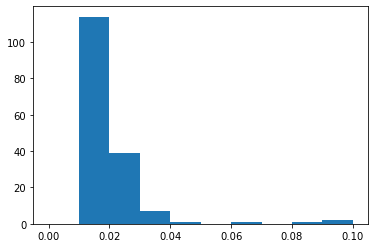

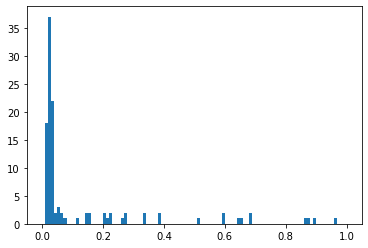

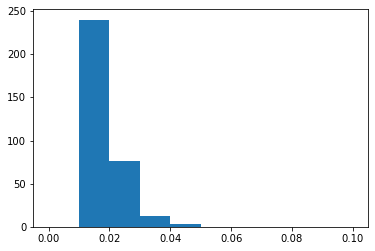

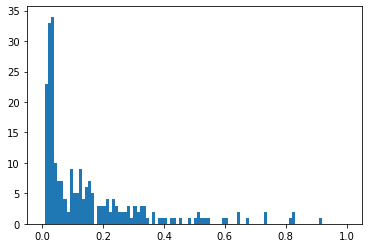

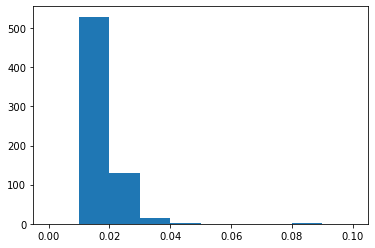

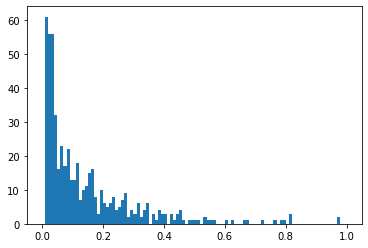

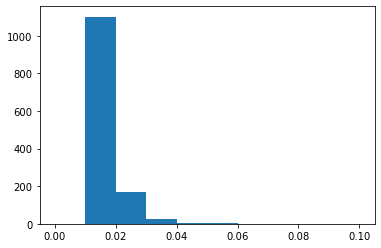

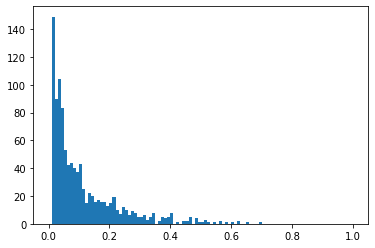

In [19]:
print('Generating histogram of H state residence times for each temperature...')

for T in range(450,901,150):
    
    file_log = str(T) + 'K/finer_res/H_rxn_E2.txt'
    log = open(file_log, 'r')
    log_lines = log.readlines()
    log_lines = [line.split() for line in log_lines]
    
    t_chemisorb = []
    t_desorb = []

    for line_index, line in enumerate(log_lines[1:]):
        
        if 'Total' in log_lines[line_index+2]:
            break
        
        if line[4] != 'NA':
            
            if 'chemisorption' in line[1]:
                t_chemisorb.append(float(line[4]))
            
            elif 'desorption' in line[1]:
                t_desorb.append(float(line[4]))
    
    t_chemisorb = np.array(t_chemisorb)
    t_desorb = np.array(t_desorb)
    
    np.save(str(T) + 'K/finer_res/t_chemisorb.npy', t_chemisorb)
    np.save(str(T) + 'K/finer_res/t_desorb.npy', t_desorb)
    
    _ = plt.hist(t_chemisorb, bins=10, range=(0.00, 0.10))
    plt.show()
    
    _ = plt.hist(t_desorb, bins=100, range=(0.00, 1.00))
    plt.show()

    log.close()